In [1]:
!pip install trimesh
!pip install torch
import os
import trimesh
import glob
import tensorflow as tf
from tensorflow import keras
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
import sys
import os
repo_path = "./Pointnet_Pointnet2_pytorch"  
sys.path.append(os.path.abspath(repo_path))
sys.path.append(os.path.abspath(os.path.join(repo_path, "models")))


In [3]:
sydney_datast = r"d:\1508Project\sydney-urban-objects-dataset\sydney-urban-objects-dataset"
objects_path = os.path.join(sydney_datast, "objects")

print(os.listdir(objects_path))

['4wd.0.2299.bin', '4wd.0.2299.bin.meta', '4wd.0.2299.csv', '4wd.1.2446.bin', '4wd.1.2446.bin.meta', '4wd.1.2446.csv', '4wd.10.17589.bin', '4wd.10.17589.bin.meta', '4wd.10.17589.csv', '4wd.11.6994.bin', '4wd.11.6994.bin.meta', '4wd.11.6994.csv', '4wd.12.3582.bin', '4wd.12.3582.bin.meta', '4wd.12.3582.csv', '4wd.13.270.bin', '4wd.13.270.bin.meta', '4wd.13.270.csv', '4wd.14.5229.bin', '4wd.14.5229.bin.meta', '4wd.14.5229.csv', '4wd.15.5563.bin', '4wd.15.5563.bin.meta', '4wd.15.5563.csv', '4wd.16.6123.bin', '4wd.16.6123.bin.meta', '4wd.16.6123.csv', '4wd.17.6783.bin', '4wd.17.6783.bin.meta', '4wd.17.6783.csv', '4wd.18.7288.bin', '4wd.18.7288.bin.meta', '4wd.18.7288.csv', '4wd.19.10974.bin', '4wd.19.10974.bin.meta', '4wd.19.10974.csv', '4wd.2.3582.bin', '4wd.2.3582.bin.meta', '4wd.2.3582.csv', '4wd.20.12346.bin', '4wd.20.12346.bin.meta', '4wd.20.12346.csv', '4wd.3.4043.bin', '4wd.3.4043.bin.meta', '4wd.3.4043.csv', '4wd.4.17038.bin', '4wd.4.17038.bin.meta', '4wd.4.17038.csv', '4wd.5.17038.

In [4]:
def read_bin(file_name):

    names = ['t','intensity','id','x','y','z','azimuth','range','pid']

    formats = ['int64', 'uint8', 'uint8',
               'float32', 'float32', 'float32',
               'float32', 'float32', 'int32']

    binType = np.dtype( dict(names=names, formats=formats) )
    data = np.fromfile(file_name, binType)

    # 3D points, one per row
    P = np.vstack([ data['x'], data['y'], data['z'] ]).T

    return P

sample = read_bin(r'C:\Users\zqt\.keras\datasets\sydney-urban-objects-dataset_extracted\sydney-urban-objects-dataset\objects\4wd.2.3582.bin')
print(sample.shape)

(204, 3)


In [5]:
labels_dict = {
    '4wd': 0,
    'bench': 1,
    'bicycle': 2,
    'biker': 3,
    'building': 4,
    'bus': 5,
    'car': 6,
    'cyclist': 7,
    'excavator': 8,
    'pedestrian': 9,
    'pillar': 10,
    'pole': 11,
    'post': 12,
    'scooter': 13,
    'ticket_machine': 14,
    'traffic_lights': 15,
    'traffic_sign': 16,
    'trailer': 17,
    'trash': 18,
    'tree': 19,
    'truck': 20,
    'trunk': 21,
    'umbrella': 22,
    'ute': 23,
    'van': 24,
    'vegetation': 25
}

num_classes = len(labels_dict)
num_classes

26

In [6]:
def sub_sample(pcs, labels, k):
    res1 = np.concatenate((pcs, np.reshape(labels, (labels.shape[0], 1))), axis=1)
    chosen = random.choices(res1, k=k)  
    chosen = np.asarray(chosen)
    
    pcs_out = chosen[:, :-1]
    labels_out = chosen[:, -1]
    return pcs_out, labels_out

class SydneyUrban(Dataset):
    def __init__(self, file_paths, labels, num_points=1024, transform=False):
        self.files = file_paths
        self.labels = labels
        self.num_points = num_points
        self.transform = transform

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        pts = read_bin(self.files[idx])
        label = self.labels[idx]
        
        if pts.shape[0] > self.num_points:
            idxs = np.random.choice(pts.shape[0], self.num_points, replace=False)
        else:
            idxs = np.random.choice(pts.shape[0], self.num_points, replace=True)
        points = pts[idxs]
        
        points[:, :3] = self.normalize(points[:, :3])
        
        points = torch.from_numpy(points).float()
        label = torch.tensor(label).long()
        
        return points, label
        
    def normalize(self, points):
        centroid = np.mean(points, axis=0)
        points -= centroid
        furthest_distance = np.max(np.sqrt(np.sum(points**2, axis=1)))
        points /= furthest_distance
        return points

In [7]:
all_files = [
    os.path.join(objects_path,f)
    for f in os.listdir(objects_path)
    if f.endswith('.bin') and not f.endswith('.bin.meta')
    ]

all_labels = []
for f in all_files:
    file_name = os.path.basename(f)
    label_str = file_name.split('.')[0]
    num_label = labels_dict[label_str]
    all_labels.append(num_label)

In [8]:
from sklearn.model_selection import train_test_split
train_files, test_files, train_labels, test_labels = train_test_split(all_files, all_labels, test_size=0.2, random_state=42) 
train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.2, random_state=42)

train_dataset = SydneyUrban(train_files, train_labels, num_points=1024)
test_dataset = SydneyUrban(test_files, test_labels, num_points=1024)
val_dataset = SydneyUrban(val_files, val_labels, num_points=1024)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

13
4
4


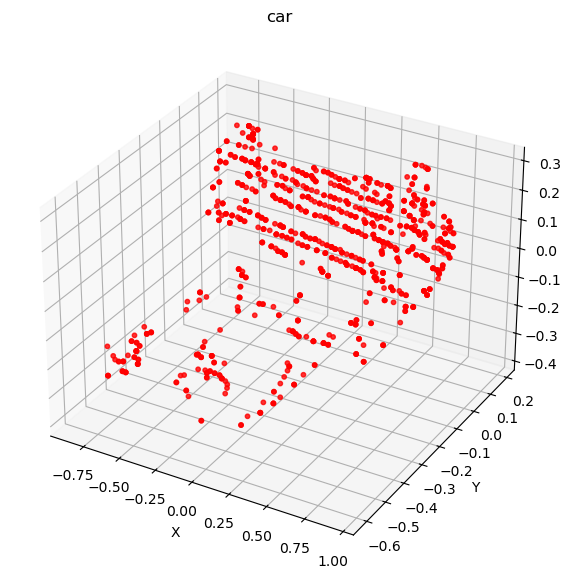

Class: car


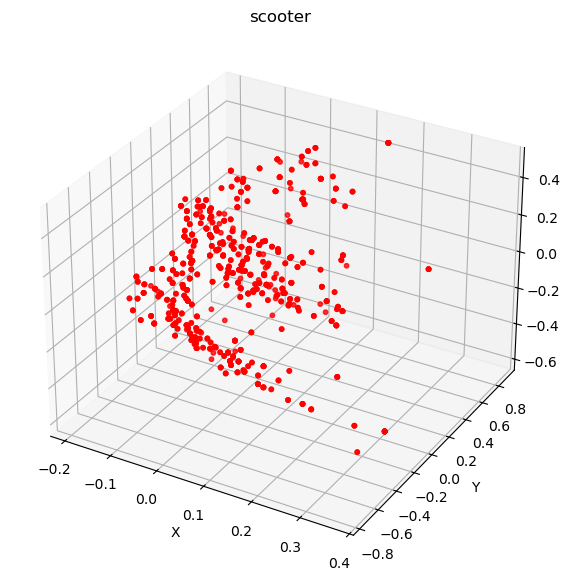

Class: scooter


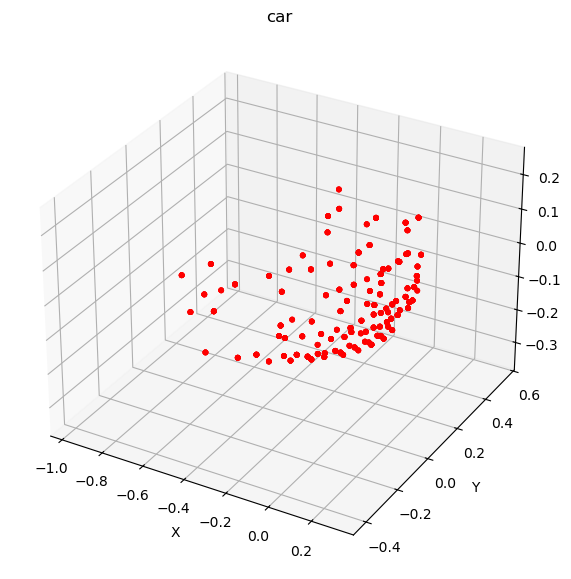

Class: car


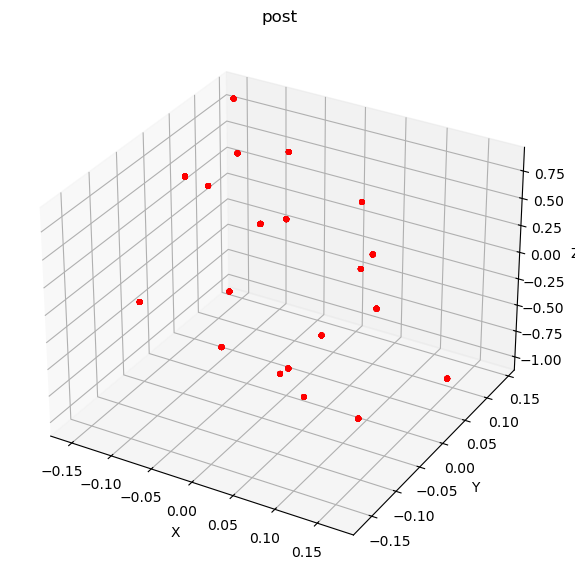

Class: post


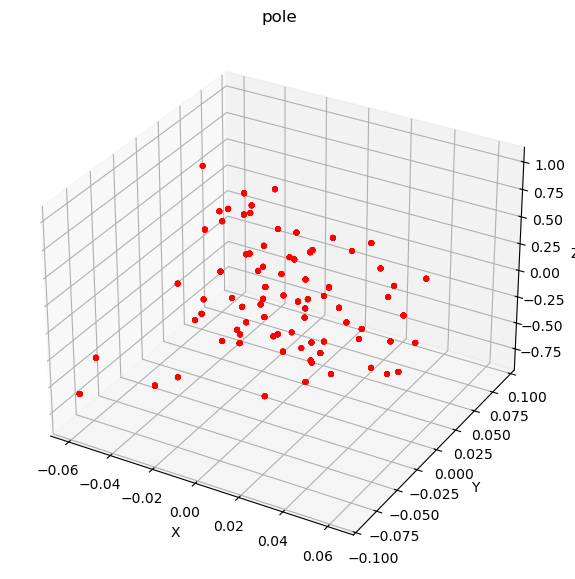

Class: pole


In [9]:
reverse_labels = {v: k for k, v in labels_dict.items()}
def plot_pc(points, title):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='o', s=10, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
    
# visualize 5 samples
for i in range(5):
    idx = np.random.randint(0, len(train_dataset))
    sample = train_dataset[idx]
    points = sample[0].numpy()
    label = sample[1].item()
    class_name = reverse_labels[label]
    
    plot_pc(points, class_name)
    print(f"Class: {class_name}")

In [10]:
class TNet(nn.Module):
  def __init__(self, k = 3):
    super().__init__()
    self.k = k

    self.conv1 = nn.Conv1d(in_channels=k, out_channels=64, kernel_size=1)
    self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1)
    self.conv3 = nn.Conv1d(in_channels=128, out_channels=1024, kernel_size=1)

    self.fc1 = nn.Linear(in_features=1024, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=k*k)

    self.bn1 = nn.BatchNorm1d(64)
    self.bn2 = nn.BatchNorm1d(128)
    self.bn3 = nn.BatchNorm1d(1024)
    self.bn4 = nn.BatchNorm1d(512)
    self.bn5 = nn.BatchNorm1d(256)

    self.dropout = nn.Dropout(p=0.3)

  def forward(self, x):
    batch_size = x.size(0)

    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))

    pool = nn.MaxPool1d(x.size(-1))(x)
    flat = nn.Flatten(1)(pool)

    x = F.relu(self.bn4(self.fc1(flat)))
    x = F.relu(self.bn5(self.dropout(self.fc2(x))))
    x = self.fc3(self.dropout(x))

    iden = torch.eye(self.k, requires_grad=False).repeat(batch_size, 1, 1).to(x.device)
    x = x.view(-1, self.k, self.k)
    x = x + iden

    return x


In [11]:
class PointNet(nn.Module):
  def __init__(self, num_classes = 26):
    super().__init__()
    self.input_transform = TNet(k = 3)
    self.feature_transform = TNet(k = 64)

    self.conv1 = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=1)
    self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1)
    self.conv3 = nn.Conv1d(in_channels=128, out_channels=1024, kernel_size=1)

    self.bn1 = nn.BatchNorm1d(64)
    self.bn2 = nn.BatchNorm1d(128)
    self.bn3 = nn.BatchNorm1d(1024)

    self.fc1 = nn.Linear(in_features=1024, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=num_classes)

    self.bn4 = nn.BatchNorm1d(512)
    self.bn5 = nn.BatchNorm1d(256)
    self.dropout = nn.Dropout(p=0.3)
    self.logsoftmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = x.transpose(1, 2)

    trans = self.input_transform(x)
    x = torch.matmul(trans, x)

    x = F.relu(self.bn1(self.conv1(x)))

    trans_feat = self.feature_transform(x)
    x = torch.matmul(trans_feat, x)


    x = F.relu(self.bn2(self.conv2(x)))
    x = self.bn3(self.conv3(x))


    pool = nn.MaxPool1d(x.size(-1))(x)
    flat = nn.Flatten(1)(pool)

    x = F.relu(self.bn4(self.fc1(flat)))
    x = F.relu(self.bn5(self.dropout(self.fc2(x))))
    x = self.fc3(self.dropout(x))

    return self.logsoftmax(x), trans, trans_feat

In [12]:
def val(model, device, loss_fn, val_loader):
    model = model.to(device)
    total_loss = 0.0
    total_correct = 0.0
    total_samples = 0

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)            
            labels = labels.to(device) 

            outputs, m3x3, m64x64 = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total_samples
    avg_accuracy = total_correct / total_samples

    return avg_loss, avg_accuracy

In [13]:
def train(model, num_epochs, device):
    model = model.to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    train_risk = []
    val_risk = []
    train_accuracy = []
    val_accuracy = []
    test_risk = []
    test_accuracy = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_correct = 0.0
        total_samples = 0

        for images, labels in train_loader:
            images = images.to(device)            
            labels = labels.to(device)            

            outputs, m3x3, m64x64 = model(images)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()



        # Calculate average training loss and accuracy over all samples
        avg_train_loss = total_loss / total_samples
        avg_train_accuracy = total_correct / total_samples

        # Evaluate on the validation set
        # (Assuming your 'val' function also uses total sample counts correctly)
        val_loss, val_acc = val(model, device, loss_function, val_loader)
        test_loss, test_acc = val(model, device, loss_function, test_loader)

        train_risk.append(avg_train_loss)
        train_accuracy.append(avg_train_accuracy)
        val_risk.append(val_loss)
        val_accuracy.append(val_acc)
        test_risk.append(test_loss)
        test_accuracy.append(test_acc)

        if (epoch + 1) % 2 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}: "
                  f"Train Risk: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, "
                  f"VAL Risk: {val_loss:.4f}, VAL Accuracy: {val_acc:.4f}")

    # Plot training and validation risk (loss)
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_risk, label='train')
    plt.plot(range(1, num_epochs+1), val_risk, label='val')
    plt.legend()
    plt.title('Train and Validation Risk')
    plt.xlabel('Epoch')
    plt.ylabel('Risk')
    plt.show()

    # Plot training and validation accuracy
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_accuracy, label='train')
    plt.plot(range(1, num_epochs+1), val_accuracy, label='val')
    plt.legend()
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    # Plot training and validation risk (loss)
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_risk, label='train')
    plt.plot(range(1, num_epochs+1), test_risk, label='test')
    plt.legend()
    plt.title('Train and Test Risk')
    plt.xlabel('Epoch')
    plt.ylabel('Risk')
    plt.show()

    # Plot training and validation accuracy
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_accuracy, label='train')
    plt.plot(range(1, num_epochs+1), test_accuracy, label='test')
    plt.legend()
    plt.title('Train and Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()


    return train_risk, val_risk, train_accuracy, val_accuracy, test_risk, test_accuracy


Training with seed 42...
Epoch 2/100: Train Risk: 0.0971, Train Accuracy: 0.3921, VAL Risk: 0.1263, VAL Accuracy: 0.1287
Epoch 4/100: Train Risk: 0.0943, Train Accuracy: 0.4194, VAL Risk: 0.1128, VAL Accuracy: 0.4455
Epoch 6/100: Train Risk: 0.0932, Train Accuracy: 0.4342, VAL Risk: 0.1140, VAL Accuracy: 0.4554
Epoch 8/100: Train Risk: 0.0927, Train Accuracy: 0.4367, VAL Risk: 0.1136, VAL Accuracy: 0.4554
Epoch 10/100: Train Risk: 0.0922, Train Accuracy: 0.4739, VAL Risk: 0.1128, VAL Accuracy: 0.5050
Epoch 12/100: Train Risk: 0.0921, Train Accuracy: 0.4764, VAL Risk: 0.1154, VAL Accuracy: 0.4158
Epoch 14/100: Train Risk: 0.0916, Train Accuracy: 0.4839, VAL Risk: 0.1130, VAL Accuracy: 0.4950
Epoch 16/100: Train Risk: 0.0913, Train Accuracy: 0.4988, VAL Risk: 0.1136, VAL Accuracy: 0.5248
Epoch 18/100: Train Risk: 0.0907, Train Accuracy: 0.5037, VAL Risk: 0.1063, VAL Accuracy: 0.5743
Epoch 20/100: Train Risk: 0.0902, Train Accuracy: 0.5261, VAL Risk: 0.1090, VAL Accuracy: 0.5644
Epoch 22

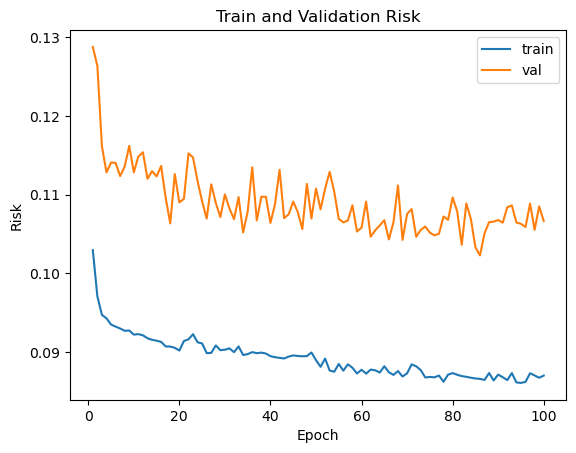

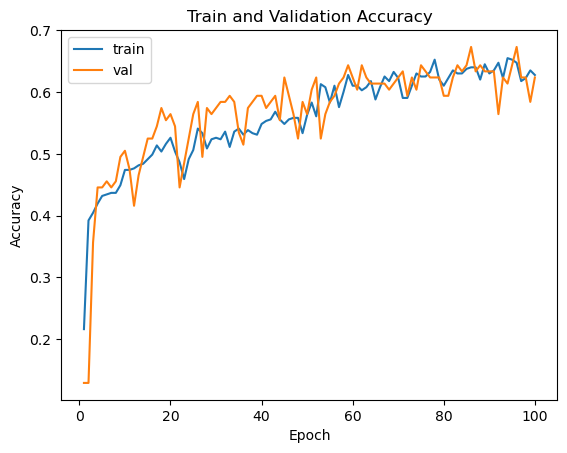

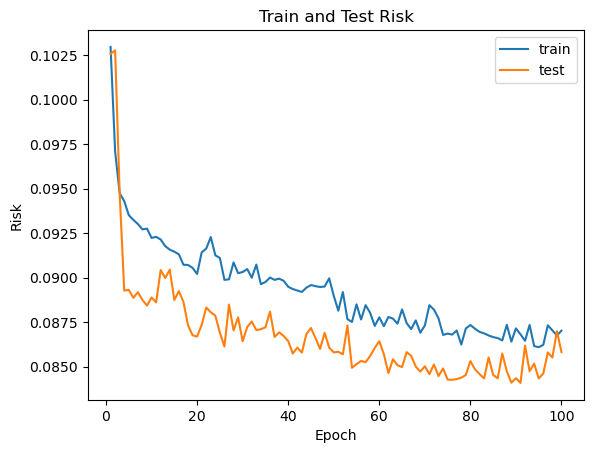

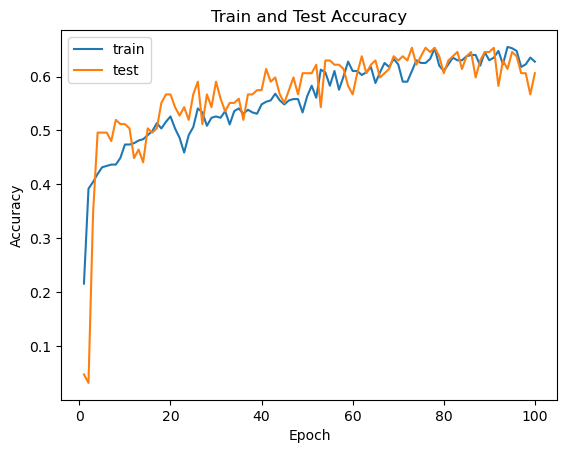


Training with seed 123...
Epoch 2/100: Train Risk: 0.0964, Train Accuracy: 0.3970, VAL Risk: 0.1233, VAL Accuracy: 0.1881
Epoch 4/100: Train Risk: 0.0937, Train Accuracy: 0.4268, VAL Risk: 0.1151, VAL Accuracy: 0.4158
Epoch 6/100: Train Risk: 0.0934, Train Accuracy: 0.4293, VAL Risk: 0.1142, VAL Accuracy: 0.3960
Epoch 8/100: Train Risk: 0.0931, Train Accuracy: 0.4342, VAL Risk: 0.1127, VAL Accuracy: 0.4653
Epoch 10/100: Train Risk: 0.0918, Train Accuracy: 0.5136, VAL Risk: 0.1104, VAL Accuracy: 0.5446
Epoch 12/100: Train Risk: 0.0922, Train Accuracy: 0.4764, VAL Risk: 0.1102, VAL Accuracy: 0.4752
Epoch 14/100: Train Risk: 0.0915, Train Accuracy: 0.4988, VAL Risk: 0.1095, VAL Accuracy: 0.4851
Epoch 16/100: Train Risk: 0.0912, Train Accuracy: 0.4963, VAL Risk: 0.1070, VAL Accuracy: 0.5545
Epoch 18/100: Train Risk: 0.0911, Train Accuracy: 0.4988, VAL Risk: 0.1092, VAL Accuracy: 0.5248
Epoch 20/100: Train Risk: 0.0908, Train Accuracy: 0.5211, VAL Risk: 0.1076, VAL Accuracy: 0.4950
Epoch 2

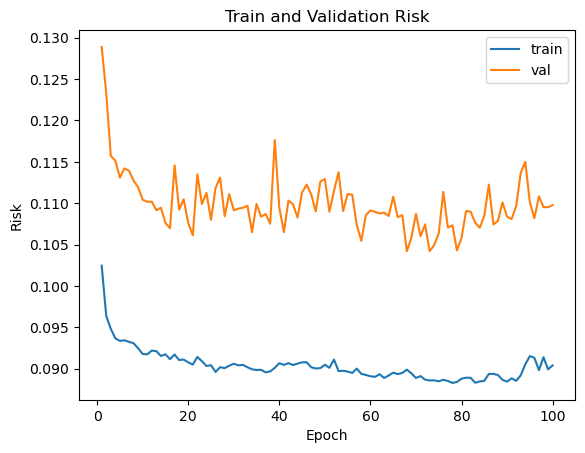

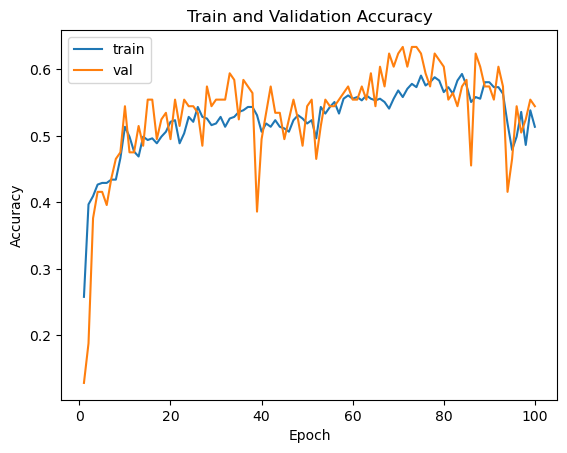

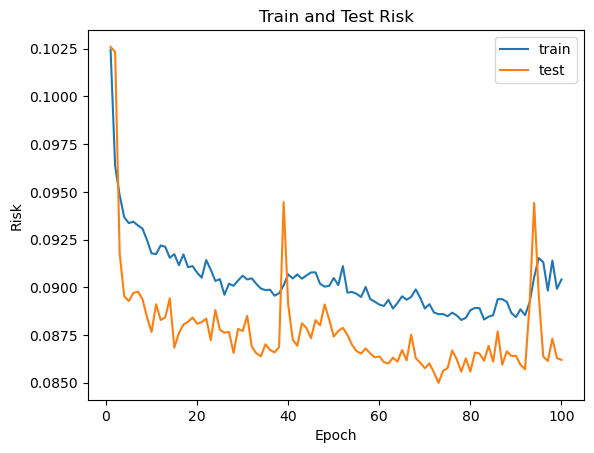

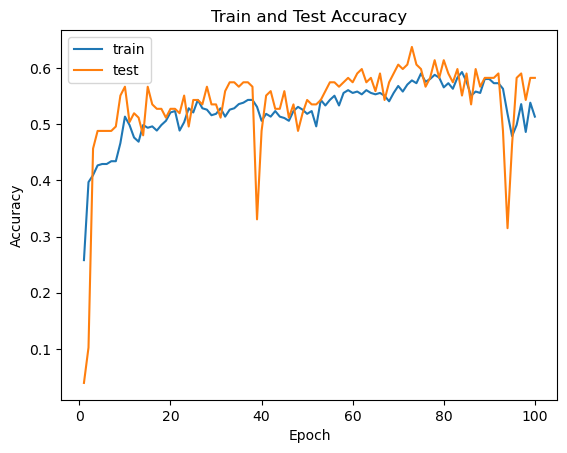


Training with seed 2023...
Epoch 2/100: Train Risk: 0.0971, Train Accuracy: 0.3921, VAL Risk: 0.1246, VAL Accuracy: 0.1683
Epoch 4/100: Train Risk: 0.0938, Train Accuracy: 0.4194, VAL Risk: 0.1161, VAL Accuracy: 0.4158
Epoch 6/100: Train Risk: 0.0933, Train Accuracy: 0.4243, VAL Risk: 0.1140, VAL Accuracy: 0.3663
Epoch 8/100: Train Risk: 0.0924, Train Accuracy: 0.4566, VAL Risk: 0.1145, VAL Accuracy: 0.5248
Epoch 10/100: Train Risk: 0.0922, Train Accuracy: 0.4739, VAL Risk: 0.1116, VAL Accuracy: 0.5446
Epoch 12/100: Train Risk: 0.0914, Train Accuracy: 0.4789, VAL Risk: 0.1138, VAL Accuracy: 0.5149
Epoch 14/100: Train Risk: 0.0925, Train Accuracy: 0.4467, VAL Risk: 0.1101, VAL Accuracy: 0.5347
Epoch 16/100: Train Risk: 0.0919, Train Accuracy: 0.4739, VAL Risk: 0.1094, VAL Accuracy: 0.5248
Epoch 18/100: Train Risk: 0.0918, Train Accuracy: 0.4814, VAL Risk: 0.1134, VAL Accuracy: 0.4752
Epoch 20/100: Train Risk: 0.0918, Train Accuracy: 0.4764, VAL Risk: 0.1146, VAL Accuracy: 0.4950
Epoch 

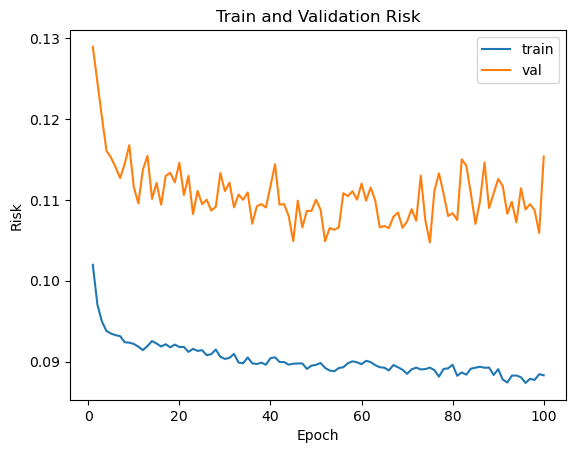

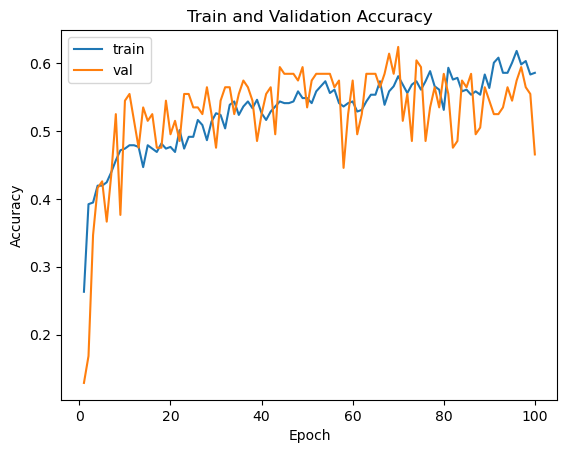

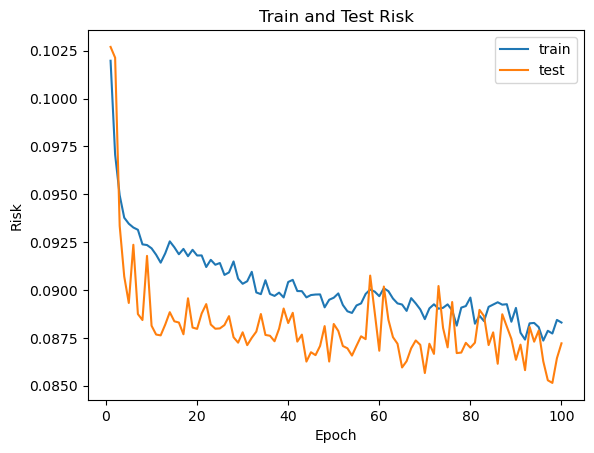

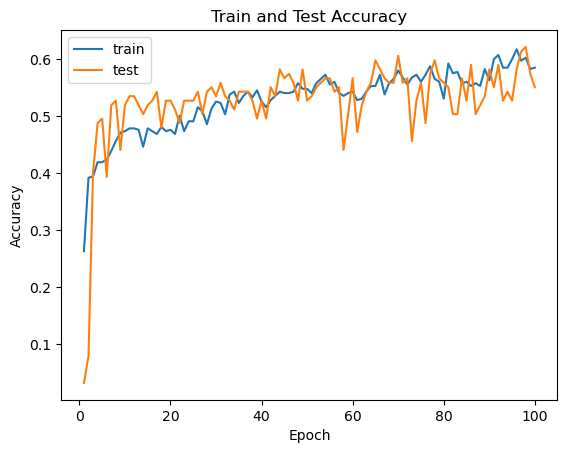


Training with seed 7...
Epoch 2/100: Train Risk: 0.0969, Train Accuracy: 0.3772, VAL Risk: 0.1257, VAL Accuracy: 0.3564
Epoch 4/100: Train Risk: 0.0943, Train Accuracy: 0.4293, VAL Risk: 0.1118, VAL Accuracy: 0.4257
Epoch 6/100: Train Risk: 0.0926, Train Accuracy: 0.4665, VAL Risk: 0.1126, VAL Accuracy: 0.5248
Epoch 8/100: Train Risk: 0.0928, Train Accuracy: 0.4566, VAL Risk: 0.1138, VAL Accuracy: 0.4752
Epoch 10/100: Train Risk: 0.0925, Train Accuracy: 0.4615, VAL Risk: 0.1137, VAL Accuracy: 0.4653
Epoch 12/100: Train Risk: 0.0918, Train Accuracy: 0.4814, VAL Risk: 0.1110, VAL Accuracy: 0.5347
Epoch 14/100: Train Risk: 0.0918, Train Accuracy: 0.4864, VAL Risk: 0.1095, VAL Accuracy: 0.5545
Epoch 16/100: Train Risk: 0.0910, Train Accuracy: 0.4988, VAL Risk: 0.1100, VAL Accuracy: 0.5347
Epoch 18/100: Train Risk: 0.0916, Train Accuracy: 0.4839, VAL Risk: 0.1086, VAL Accuracy: 0.5248
Epoch 20/100: Train Risk: 0.0915, Train Accuracy: 0.4864, VAL Risk: 0.1120, VAL Accuracy: 0.5248
Epoch 22/

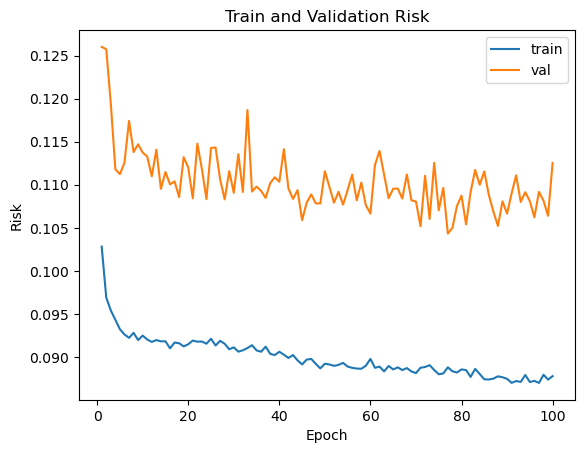

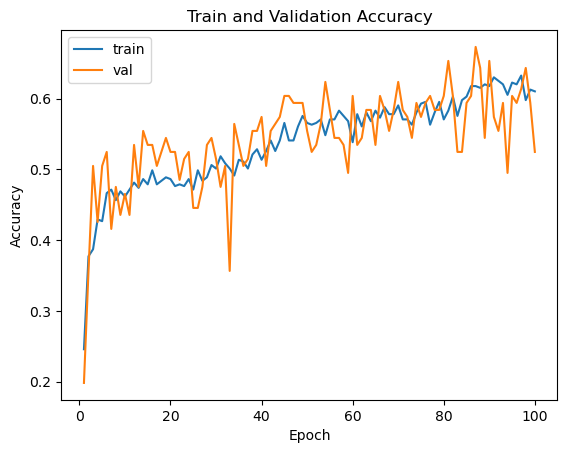

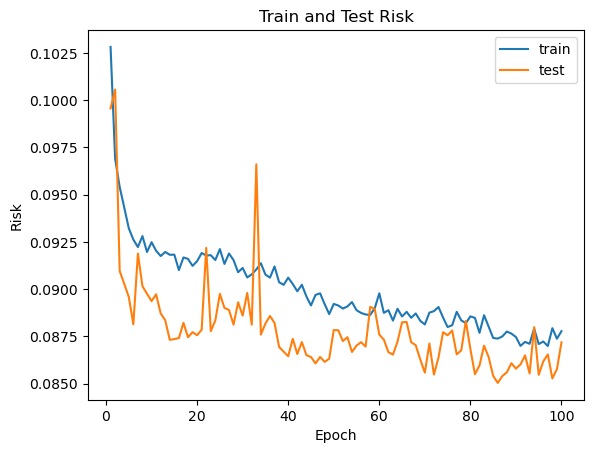

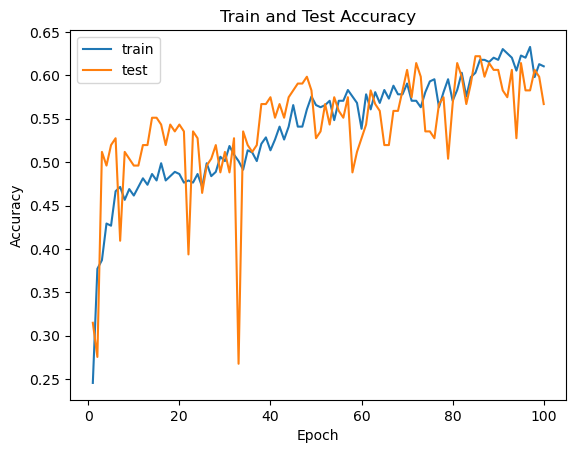


Training with seed 999...
Epoch 2/100: Train Risk: 0.0968, Train Accuracy: 0.4144, VAL Risk: 0.1256, VAL Accuracy: 0.2178
Epoch 4/100: Train Risk: 0.0939, Train Accuracy: 0.4144, VAL Risk: 0.1131, VAL Accuracy: 0.4356
Epoch 6/100: Train Risk: 0.0927, Train Accuracy: 0.4367, VAL Risk: 0.1156, VAL Accuracy: 0.4653
Epoch 8/100: Train Risk: 0.0925, Train Accuracy: 0.4591, VAL Risk: 0.1130, VAL Accuracy: 0.5050
Epoch 10/100: Train Risk: 0.0923, Train Accuracy: 0.4516, VAL Risk: 0.1133, VAL Accuracy: 0.4752
Epoch 12/100: Train Risk: 0.0927, Train Accuracy: 0.4615, VAL Risk: 0.1142, VAL Accuracy: 0.5050
Epoch 14/100: Train Risk: 0.0915, Train Accuracy: 0.4913, VAL Risk: 0.1145, VAL Accuracy: 0.5644
Epoch 16/100: Train Risk: 0.0917, Train Accuracy: 0.4814, VAL Risk: 0.1054, VAL Accuracy: 0.5743
Epoch 18/100: Train Risk: 0.0913, Train Accuracy: 0.4963, VAL Risk: 0.1092, VAL Accuracy: 0.5545
Epoch 20/100: Train Risk: 0.0908, Train Accuracy: 0.5087, VAL Risk: 0.1067, VAL Accuracy: 0.5743
Epoch 2

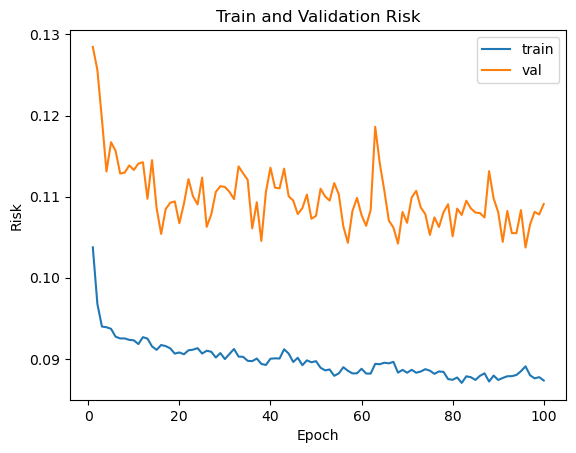

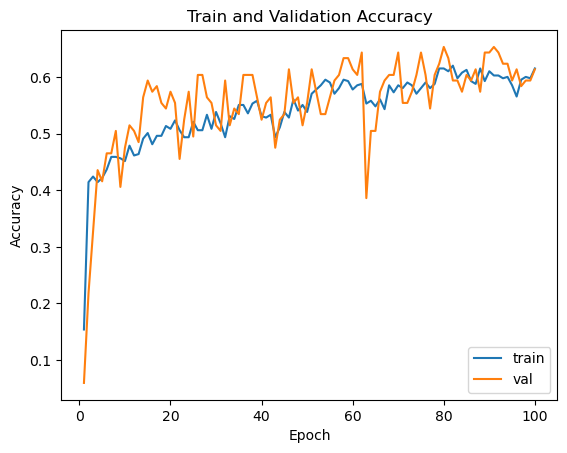

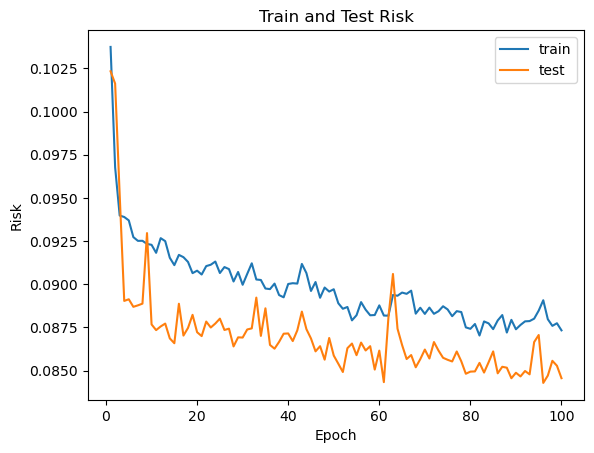

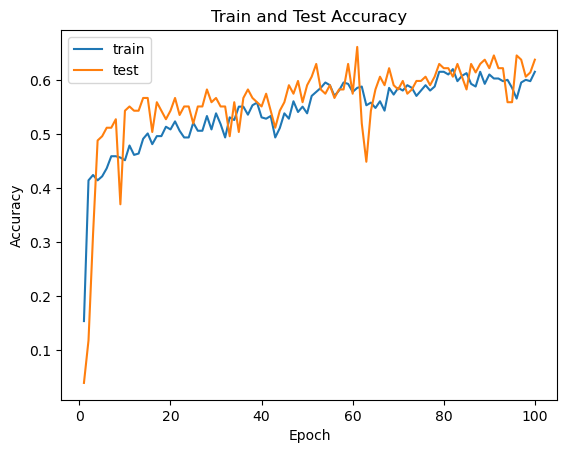


--- Averaged Over Seeds ---
Test Accuracy (final): 0.5890 ± 0.0305
Test Loss (final): 0.0862 ± 0.0010


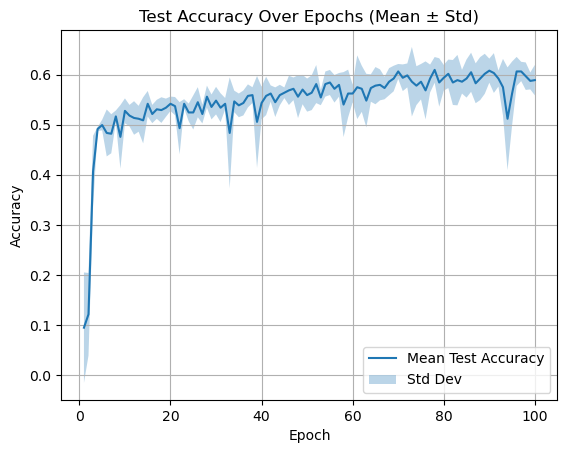

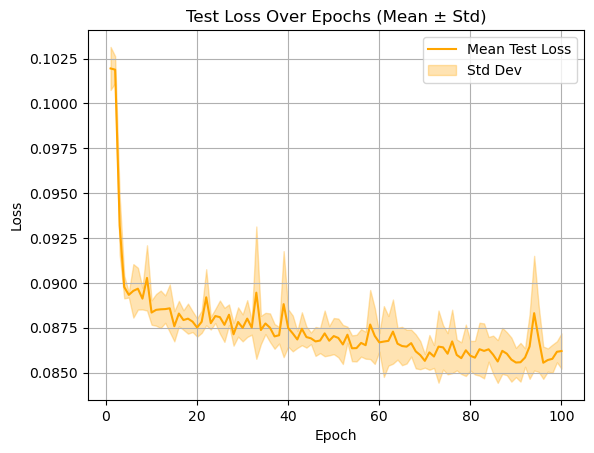

In [15]:
seeds = [42, 123, 2023, 7, 999]
all_test_accuracies = []
all_test_losses = []

test_accuracies = []
test_losses = []

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for seed in seeds:
    print(f"\nTraining with seed {seed}...")
    set_seed(seed)

    pointnet = PointNet().to(device)

    # Train and collect full test curve
    _, _, _, _, test_risk, test_accuracy = train(pointnet, num_epochs=num_epochs, device=device)

    all_test_accuracies.append(test_accuracy)
    all_test_losses.append(test_risk)

    # Save last epoch's final values
    test_accuracies.append(test_accuracy[-1])
    test_losses.append(test_risk[-1])

# --- Final Stats ---
mean_acc = np.mean(test_accuracies)
std_acc = np.std(test_accuracies)
mean_loss = np.mean(test_losses)
std_loss = np.std(test_losses)

print("\n--- Averaged Over Seeds ---")
print(f"Test Accuracy (final): {mean_acc:.4f} ± {std_acc:.4f}")
print(f"Test Loss (final): {mean_loss:.4f} ± {std_loss:.4f}")

# --- Plot average test accuracy/loss curves ---
import matplotlib.pyplot as plt

epochs = np.arange(1, num_epochs + 1)
acc_array = np.array(all_test_accuracies)
loss_array = np.array(all_test_losses)

mean_acc_curve = np.mean(acc_array, axis=0)
std_acc_curve = np.std(acc_array, axis=0)

mean_loss_curve = np.mean(loss_array, axis=0)
std_loss_curve = np.std(loss_array, axis=0)

# --- Plot Test Accuracy Curve ---
plt.figure()
plt.plot(epochs, mean_acc_curve, label='Mean Test Accuracy')
plt.fill_between(epochs, mean_acc_curve - std_acc_curve, mean_acc_curve + std_acc_curve, alpha=0.3, label='Std Dev')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs (Mean ± Std)')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot Test Loss Curve ---
plt.figure()
plt.plot(epochs, mean_loss_curve, label='Mean Test Loss', color='orange')
plt.fill_between(epochs, mean_loss_curve - std_loss_curve, mean_loss_curve + std_loss_curve, alpha=0.3, color='orange', label='Std Dev')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Over Epochs (Mean ± Std)')
plt.legend()
plt.grid(True)
plt.show()
    
        
